In [51]:
# Import Appropriate Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Flatten, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from prophet import Prophet
import logging

In [2]:
# Read the data from the csv file
df  = pd.read_csv("powerconsumption.csv") #Import the data into a dataframe
df.head() #Show the first lines of the dataframe


Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

In [3]:
# Explore the column names and the type of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [7]:
# Explore the Missing values
print(df.isnull().sum())

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64


In [9]:
# Check the statistics of the data fields
df.describe()

Temperature      Humidity     WindSpeed  GeneralDiffuseFlows  \
count  52416.000000  52416.000000  52416.000000         52416.000000   
mean      18.810024     68.259518      1.959489           182.696614   
std        5.815476     15.551177      2.348862           264.400960   
min        3.247000     11.340000      0.050000             0.004000   
25%       14.410000     58.310000      0.078000             0.062000   
50%       18.780000     69.860000      0.086000             5.035500   
75%       22.890000     81.400000      4.915000           319.600000   
max       40.010000     94.800000      6.483000          1163.000000   

       DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
count  52416.000000            52416.000000            52416.000000   
mean      75.028022            32344.970564            21042.509082   
std      124.210949             7130.562564             5201.465892   
min        0.011000            13895.696200             8560.081466   
25%        0.122000            26310.668692            16980.766032   
50%        4.456000            32265.920340            20823.168405   
75%      101.000000            37309.018185            24713.717520   
max      936.000000            52204.395120            37408.860760   

       PowerConsumption_Zone3  
count            52416.000000  
mean             17835.406218  
std               6622.165099  
min               5935.174070  
25%              13129.326630  
50%              16415.117470  
75%              21624.100420  
max              47598.326360

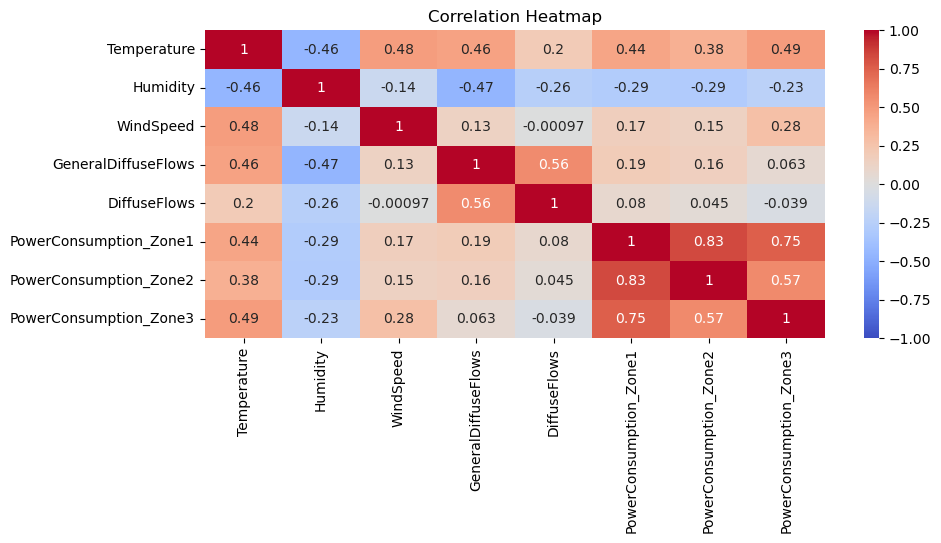

In [13]:
# Selecting numerical features only
df_numeric = df.select_dtypes(include=['float64'])

# Heatmap on numerical features
plt.figure(figsize=(10, 4))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

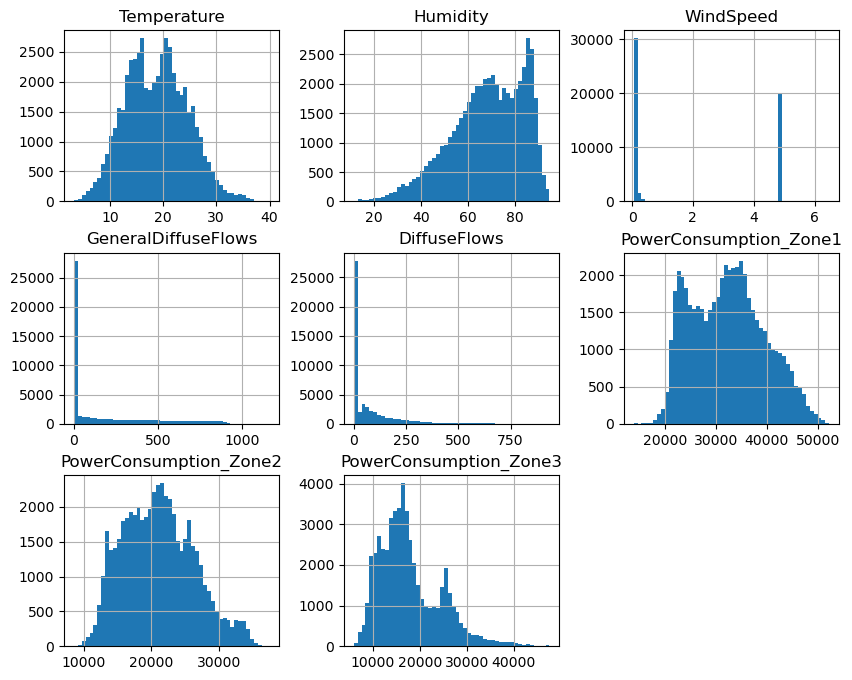

In [15]:
# Histogram for numerical variables
df_numeric.hist(bins=50, figsize=(10, 8))
plt.show()

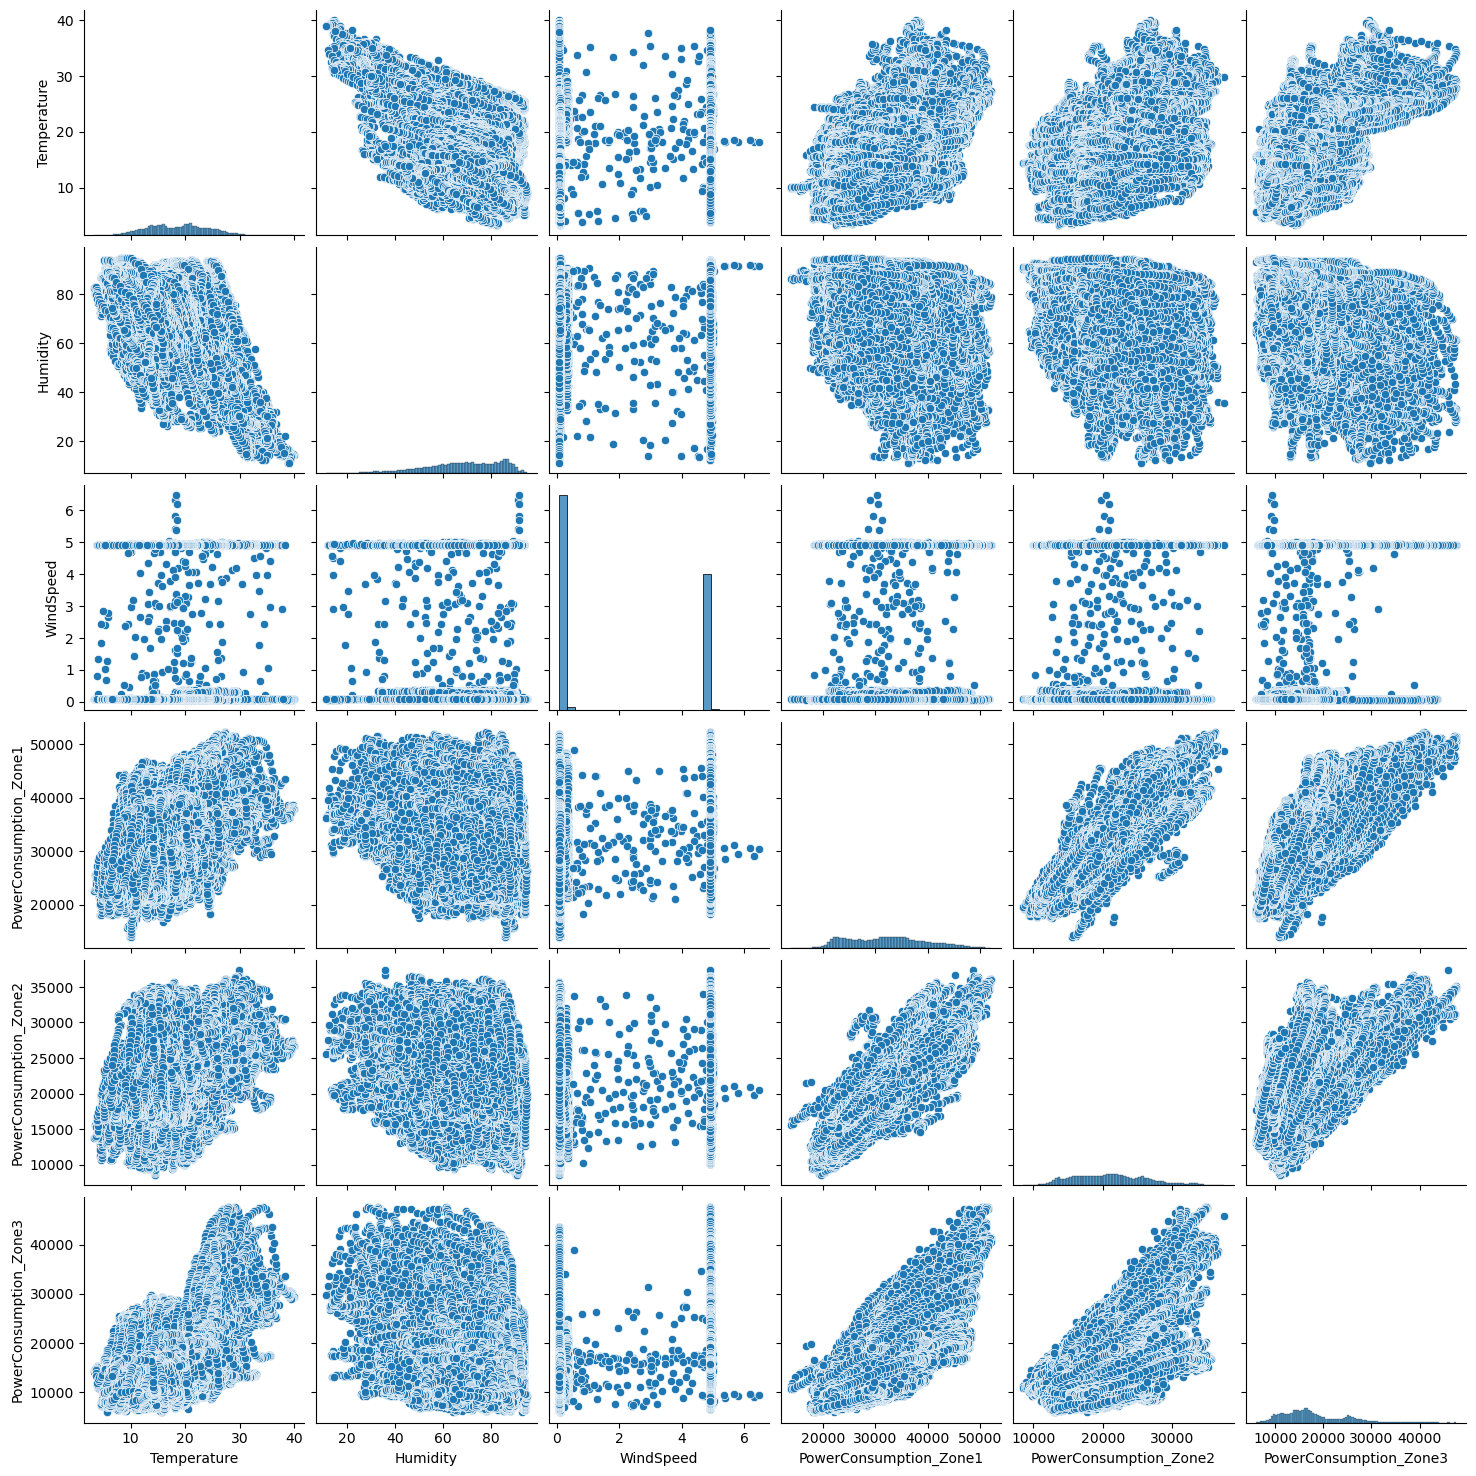

In [17]:
#Data Visualization
# Pairplot to visualize relationships between numerical columns
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

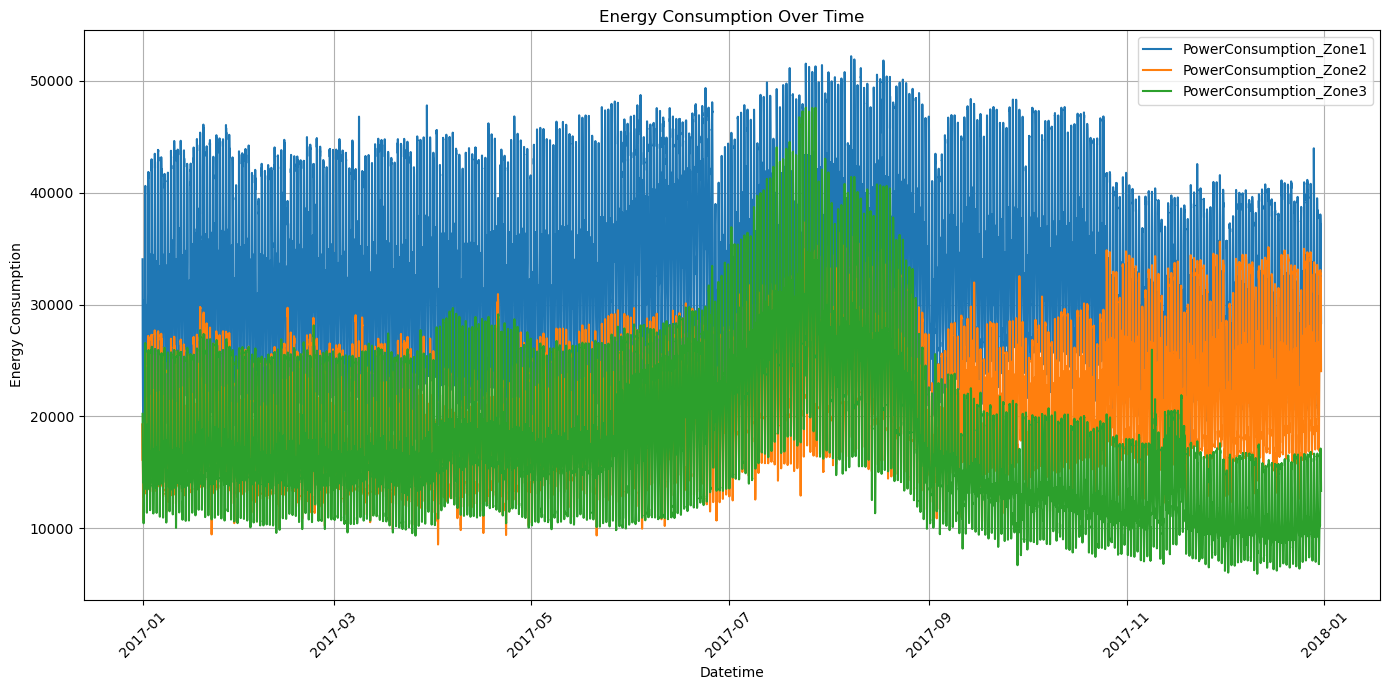

In [11]:
# Plotting energy consumption for the last three columns
# Convert the 'Datetime' column to datetime format. 

df['Datetime'] = pd.to_datetime(df['Datetime'])

plt.figure(figsize=(14, 7))

for col in df.columns[-3:]:  # Select the last three columns
    plt.plot(df['Datetime'], df[col], label=col)

plt.xlabel('Datetime')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


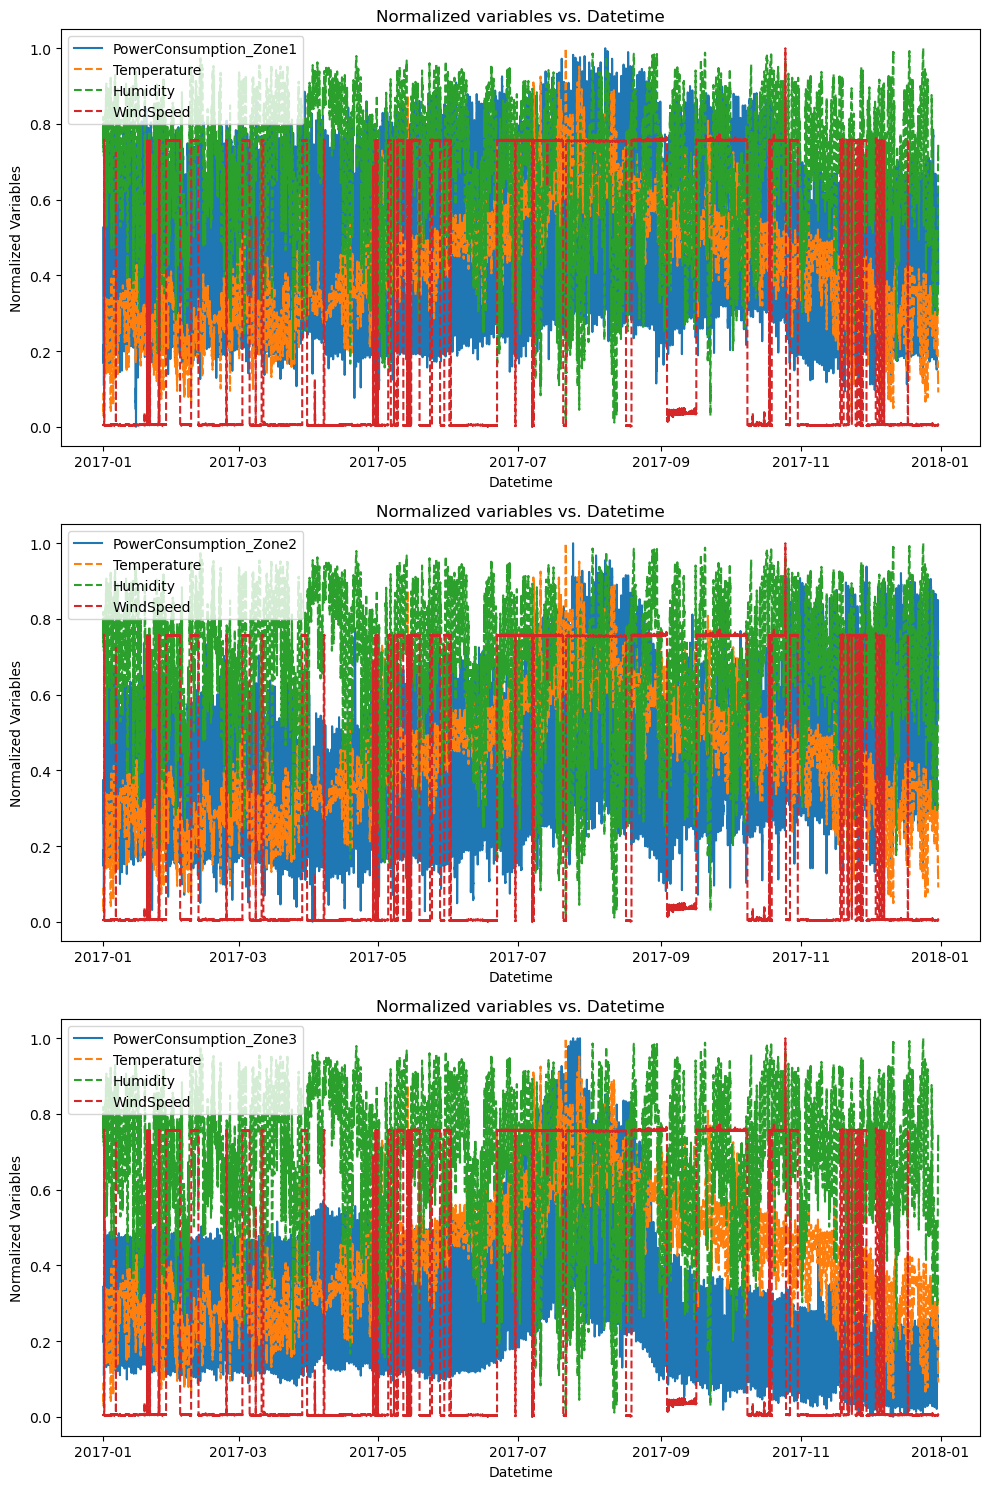

In [19]:
# Normalize all columns except 'Datetime' to be able to plot all imprortant variables on the same plot
numeric_cols = df.select_dtypes(include=np.number).columns
df_normalized = df.copy()
for col in numeric_cols:
    if col != 'Datetime':
        df_normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

last_three_cols = df_normalized.columns[-3:]

for i, col in enumerate(last_three_cols):
    axes[i].plot(df_normalized['Datetime'], df_normalized[col], label=col)
    axes[i].set_xlabel("Datetime")
    axes[i].set_ylabel(f"Normalized Variables")
    axes[i].set_title(f"Normalized variables vs. Datetime")
    axes[i].legend()

    # Add Temperature, Humidity, and WindSpeed as a function of Datetime
    axes[i].plot(df_normalized['Datetime'], df_normalized['Temperature'], label='Temperature', linestyle='--')
    axes[i].plot(df_normalized['Datetime'], df_normalized['Humidity'], label='Humidity', linestyle='--')
    axes[i].plot(df_normalized['Datetime'], df_normalized['WindSpeed'], label='WindSpeed', linestyle='--')


    axes[i].legend()

plt.tight_layout()
plt.show()

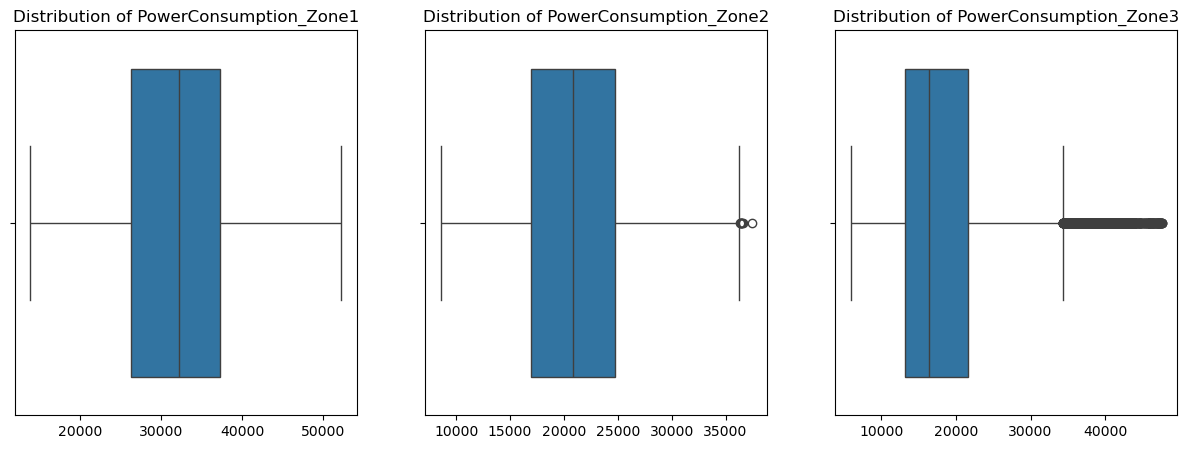

In [25]:
# Target variable analysis
# We have some outliers in zone 3 power consunmption data
fig,ax=plt.subplots(1,3,figsize=(15,5))
for index,i in enumerate(['PowerConsumption_Zone1','PowerConsumption_Zone2', 'PowerConsumption_Zone3']):
    sns.boxplot(x=df[i],ax=ax[index]).set(title=f'Distribution of {i}',xlabel=None)

In [27]:
# Determine if there are any duplicate rows to remove?
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
  print("Duplicate rows found:")
  print(duplicate_rows)
else:
  print("No duplicate rows found.")

No duplicate rows found.


## SFS to Detemine the Most Important Features

In [29]:
# Using sequential feature selection method to select most important parameters that affect the PowerConsumption_Zone1, PowerConsumption_Zone2, and PowerConsumption_Zone3
# Define features (X) and target variables (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3', 'Datetime'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize the estimator (Linear Regression)
estimator = LinearRegression()

# Initialize Sequential Feature Selector
sfs = SequentialFeatureSelector(estimator, n_features_to_select=3, direction='forward') # Adjust n_features_to_select

# Fit the SFS to your data
sfs.fit(X, y)

# Get the selected features
selected_features = list(X.columns[sfs.get_support()])

# Print the selected features
print("Selected features:", selected_features)

Selected features: ['Temperature', 'Humidity', 'WindSpeed']


In [31]:
#Scaling the target variables
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [33]:
# Select Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y_scaled, test_size=0.2, random_state=42)

## Ridge Regression and GridSearchCV

In [35]:
# Using Ridge Regression and GridSearchCV to Optimize the model 
pipeline = Pipeline([
    ('poly', PolynomialFeatures()), # Example degree, tune as needed
    ('scaler', MinMaxScaler()),
    ('ridge', Ridge())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2],  # Example degrees, adjust as needed
    'ridge__alpha': [0.01, 0.1, 1, 5, 10, 50, 100, 200, 500]  # Example alpha values, adjust as needed
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error') # Use 5-fold cross-validation

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the training and testing data using the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Testing R^2: {test_r2}")

# Print the coefficients of the best model
print("Coefficients of the best model:")
print(best_model.named_steps['ridge'].coef_)
print (best_model.named_steps['poly'].get_feature_names_out())


#Running one sample test for prediction
X_test_df = pd.DataFrame(np.array([[6.559, 73.8, 0.083]]), columns=selected_features)
Result_pred=best_model.predict(X_test_df)
inversed = scaler_y.inverse_transform(Result_pred)
print(f"The sample test: {inversed}")

Training RMSE: 0.8662472002835534
Testing RMSE: 0.8616285959986224
Training R^2: 0.2494728198547647
Testing R^2: 0.2529117355248151
Coefficients of the best model:
[[  0.          -3.97457144   0.04781376  -2.67788177   3.59303859
    3.1070159    0.23352208  -2.25301613  -0.87057995   3.91085749]
 [  0.          -6.41953039   0.30810171  -4.11636097   5.54200506
    3.08628025   0.84363154  -2.71360674  -0.3752001    4.7982331 ]
 [  0.         -11.35885033  -0.46819289  -7.31639109  10.63211145
    3.92258038   1.71040978  -1.65284291  -1.13086946   9.16070243]]
['1' 'Temperature' 'Humidity' 'WindSpeed' 'Temperature^2'
 'Temperature Humidity' 'Temperature WindSpeed' 'Humidity^2'
 'Humidity WindSpeed' 'WindSpeed^2']
The sample test: [[27609.31903459 19509.39348391 17057.21693604]]


## Lasso Regression and GridSearchCV

In [37]:
# Using Lasso Regression and GridSearchCV to Optimize the model 
param_grid = {
    'poly__degree': [1, 2],  # Example degrees, adjust as needed
    'lasso__alpha': [0.01, 0.1, 1, 10, 100]  # Example alpha values, adjust as needed
}

# Create the pipeline with Lasso regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', MinMaxScaler()),
    ('lasso', Lasso())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error') # Use 5-fold cross-validation

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the training and testing data using the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Testing R^2: {test_r2}")

# Print the coefficients of the best model
print("Coefficients of the best model:")
print(best_model.named_steps['lasso'].coef_)
print (best_model.named_steps['poly'].get_feature_names_out())


#Running one sample test for prediction
X_test_df = pd.DataFrame(np.array([[6.559, 73.8, 0.083]]), columns=selected_features)
Result_pred=best_model.predict(X_test_df)
inversed = scaler_y.inverse_transform(Result_pred)
print(f"The sample test: {inversed}")

Training RMSE: 0.8880385271379067
Testing RMSE: 0.8825959270161481
Training R^2: 0.2117511925421873
Testing R^2: 0.2165728921098221
Coefficients of the best model:
[[ 0.          1.84863975 -0.         -0.          0.          0.23927985
   0.         -0.60742444 -0.         -0.        ]
 [ 0.          1.56811664 -0.          0.          0.          0.
   0.04474025 -0.6375324  -0.          0.        ]
 [ 0.          0.         -0.         -0.          2.5228103   0.
   0.41795044 -0.         -0.         -0.        ]]
['1' 'Temperature' 'Humidity' 'WindSpeed' 'Temperature^2'
 'Temperature Humidity' 'Temperature WindSpeed' 'Humidity^2'
 'Humidity WindSpeed' 'WindSpeed^2']
The sample test: [[27033.21959522 18039.81974147 13526.24236516]]


## Time Series Analysis (using ARIMA)

In [13]:
# 1. Prepare the data for ARIMA method - For the timeseries, i focused on Zone 1 power prediction
data = df['PowerConsumption_Zone1']  # We can simply replace 'PowerConsumption_Zone1' if wre are interested to predict power consumption for other zones.

decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=144) # Use 'additive' approach here

# 2. Extract the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid




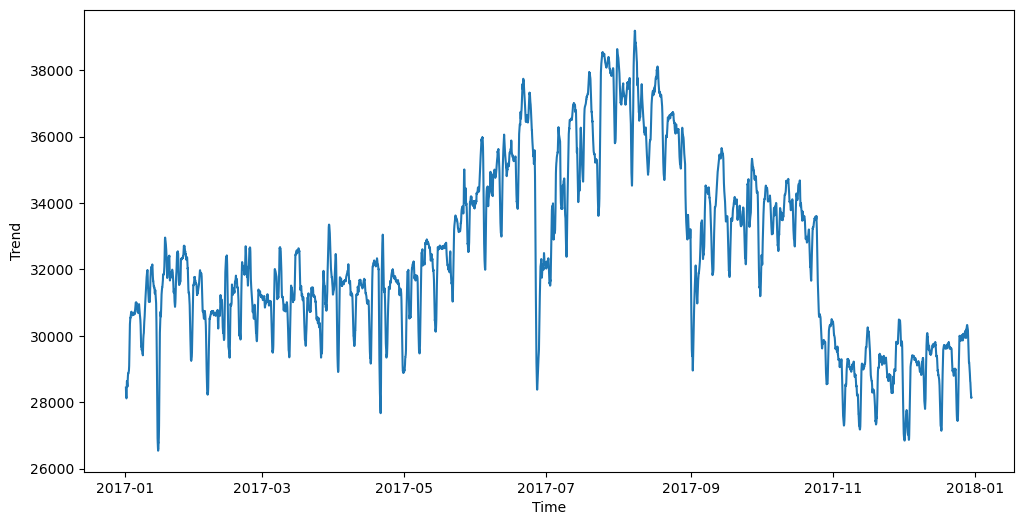

In [15]:
# Plot the trend component
plt.figure(figsize=(12, 6))
plt.plot(df[['Datetime']], trend.values[:])
plt.xlabel("Time")
plt.ylabel("Trend")
plt.show()

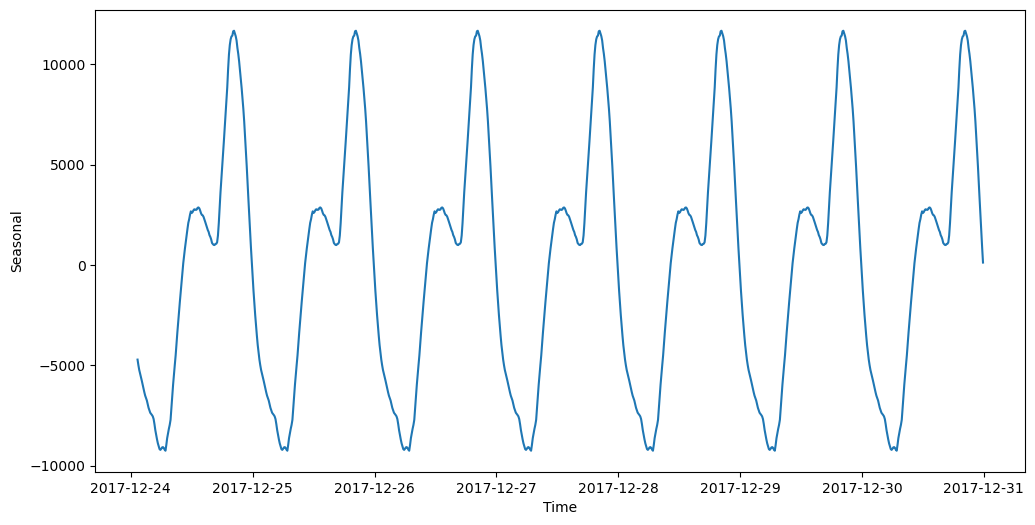

In [17]:
# Plot only the last 1000 points of the Seaasonal component so that the changes are visible.
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'].iloc[-1000:], seasonal.values[-1000:])
plt.xlabel("Time")
plt.ylabel("Seasonal")
plt.show()

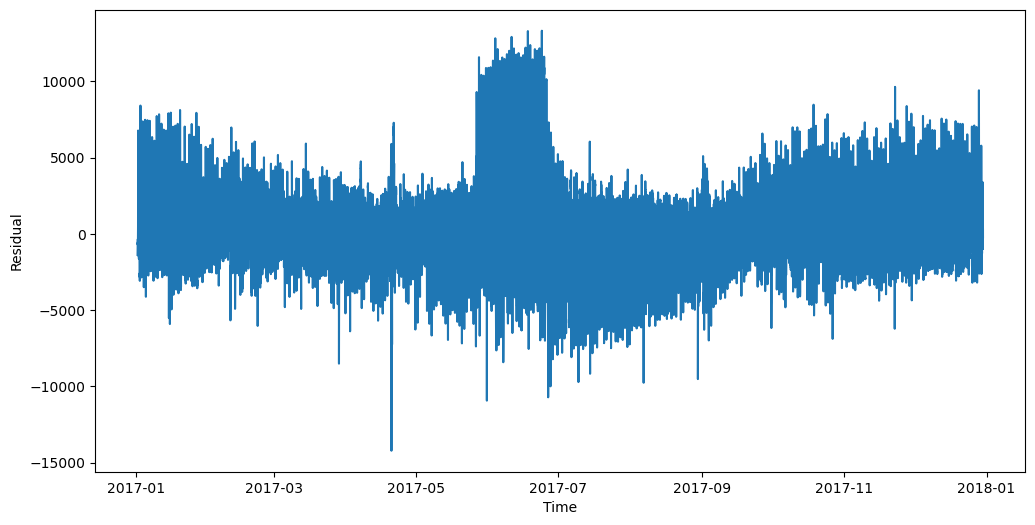

In [19]:
# Plot the 'Residual' feature
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'], residual)
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

ADF Statistic: -35.675345
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


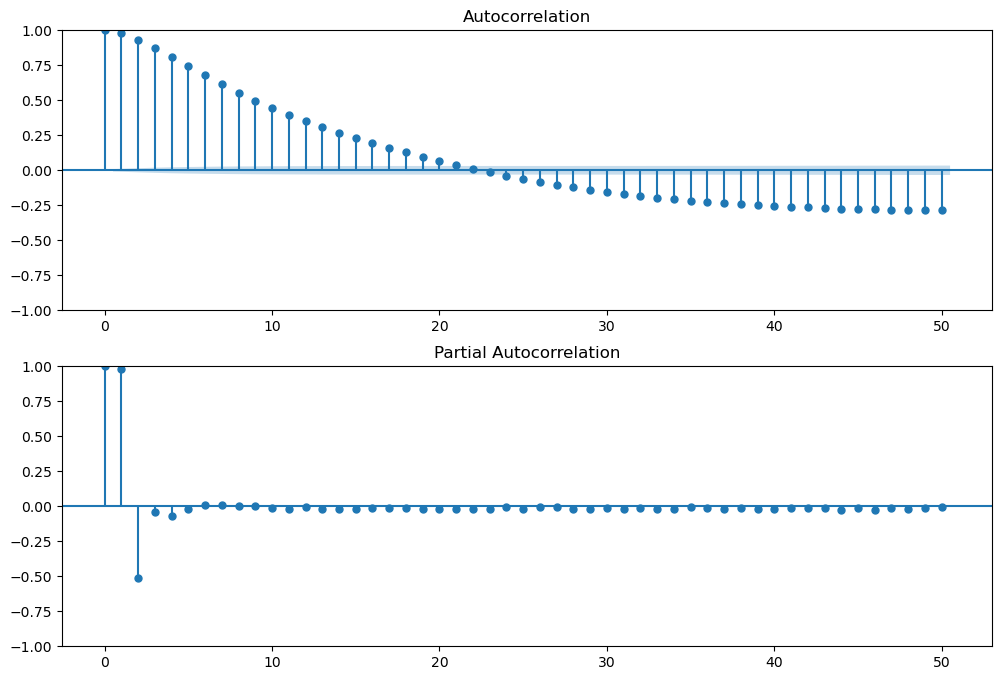

In [50]:
# Use AD-FUller Approach to test if the residual data is stationary 
result = adfuller(residual.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot Autocorrelation and Partial Autocorrolation functions to detemine the optimal p and q
plot_acf(residual.dropna(), lags=50, ax=ax1)
plot_pacf(residual.dropna(), lags=50, ax=ax2)

plt.show()

   

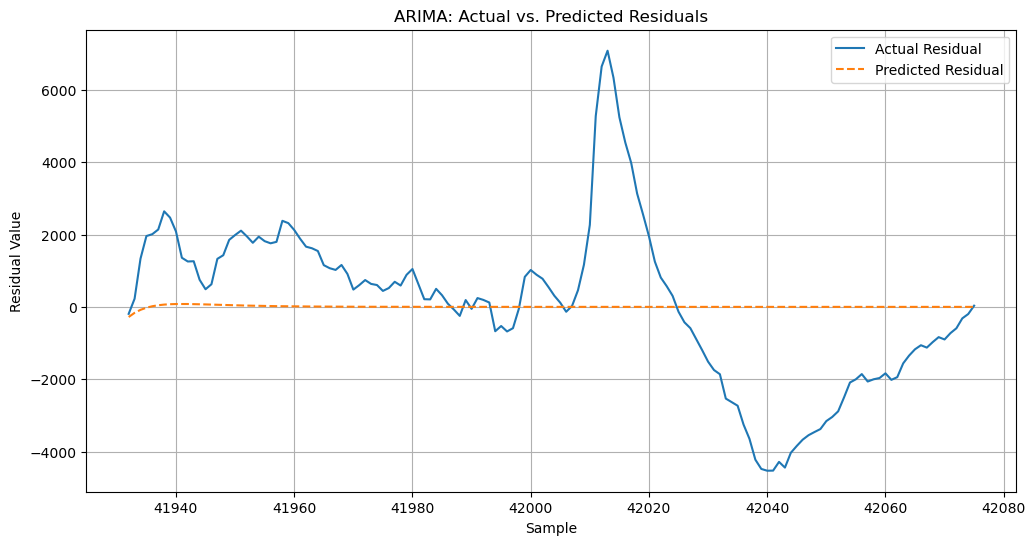

In [51]:
# Split data into train and test
train_size = int(len(residual) * 0.8)
train, test = residual.iloc[:train_size], residual.iloc[train_size:]

# 1. Create and fit the ARIMA model
model = ARIMA(train, order=(2, 0, 2))
model_fit = model.fit()

# 2. Make forecasts for 24 hours starting after the training data
forecast_steps = 144
ARIMA_forecast = model_fit.forecast(steps=forecast_steps)

forecast_index = test.index[:forecast_steps]

# 3. Plot the results
plt.figure(figsize=(12, 6))

# Plot actual test data for the corresponding steps
plt.plot(forecast_index, test.iloc[:forecast_steps], label='Actual Residual')

# Plot forecast values for steps
plt.plot(forecast_index, ARIMA_forecast, label='Predicted Residual', linestyle='--')

plt.title('ARIMA: Actual vs. Predicted Residuals')
plt.xlabel('Sample')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

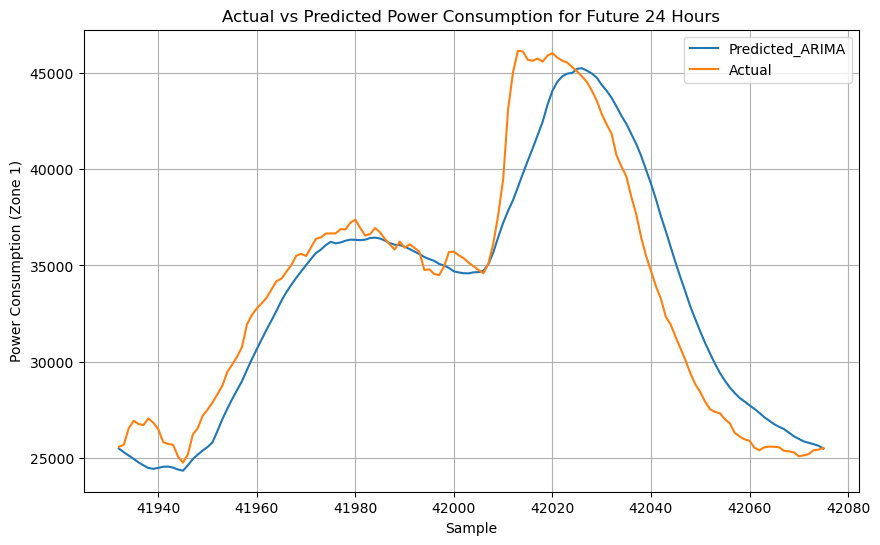

In [129]:
# Reconstruct the signal and measure the accuracy based on RMSE
Reconstructed_signal = trend.iloc[len(train):len(train)+forecast_steps] + seasonal.iloc[len(train):len(train)+forecast_steps] + ARIMA_forecast
Original_signal = data.iloc[len(train):len(train)+forecast_steps]
plt.figure(figsize=(10, 6))
plt.plot(Reconstructed_signal, label='Predicted_ARIMA')
plt.plot(Original_signal, label='Actual')
plt.xlabel("Sample")
plt.ylabel("Power Consumption (Zone 1)")
plt.title("Actual vs Predicted Power Consumption for Future 24 Hours")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Compute ARIMA method's MSE and RMSE
arima_mse = mean_squared_error(Reconstructed_signal,Original_signal)
arima_rmse = np.sqrt(arima_mse)
print(arima_mse, arima_rmse)

4889628.084395313 2211.2503441255385


## Time Series Analysis (using SARIMA)

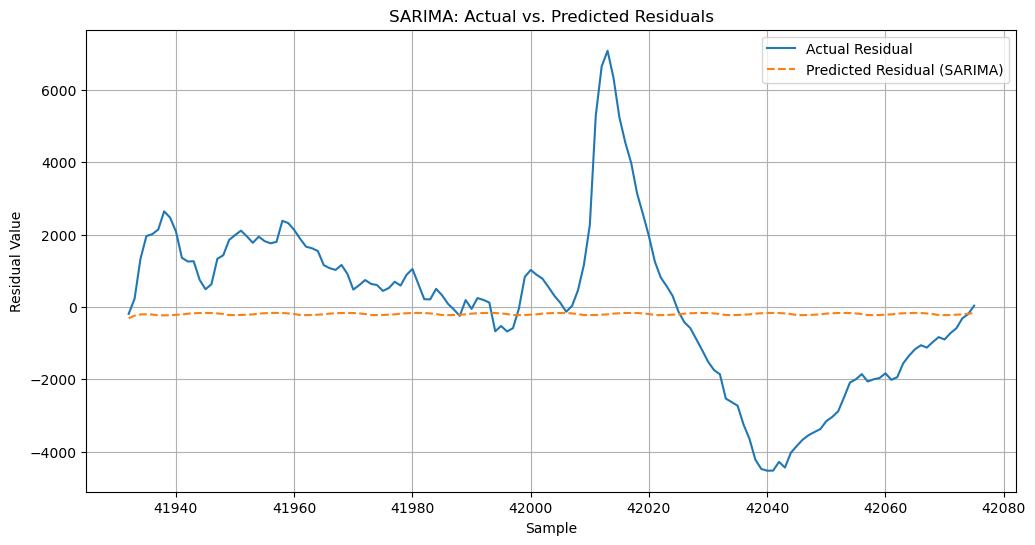

In [55]:
# Split data into train and test
train_size = int(len(residual) * 0.8)
train, test = residual.iloc[:train_size], residual.iloc[train_size:]

# 1. Define the SARIMA model
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# 2. Forecast for the next steps
forecast_steps = 144
SARIMA_forecast = model_fit.forecast(steps=forecast_steps)

# Use actual test data indices if available
forecast_index = test.index[:forecast_steps]

# 3. Plot the results
plt.figure(figsize=(12, 6))

# Plot actual test data for the corresponding steps
plt.plot(forecast_index, test.iloc[:forecast_steps], label='Actual Residual')

# Plot forecast values for next steps
plt.plot(forecast_index, SARIMA_forecast, label='Predicted Residual (SARIMA)', linestyle='--')

plt.title('SARIMA: Actual vs. Predicted Residuals')
plt.xlabel('Sample')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

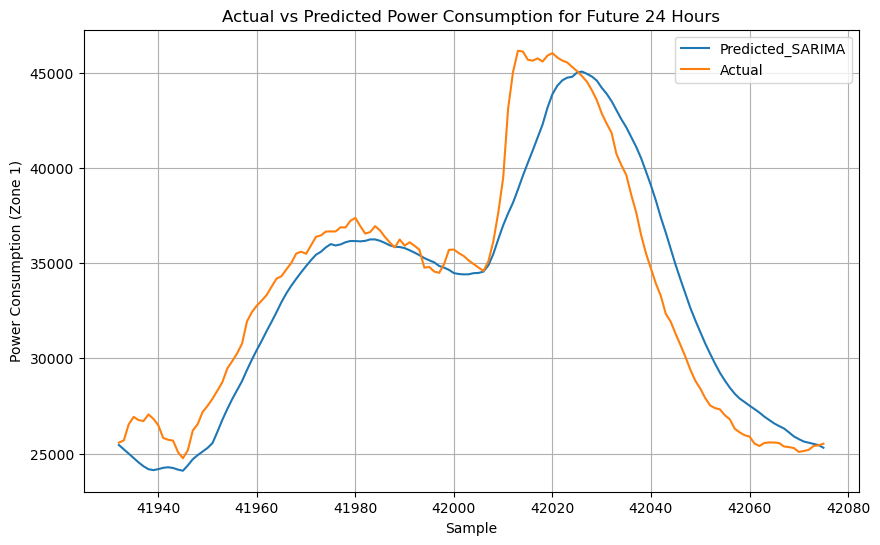

In [56]:
# Reconstruct the signal
Reconstructed_signal_SARIMA = trend.iloc[len(train):len(train)+forecast_steps] + seasonal.iloc[len(train):len(train)+forecast_steps] + SARIMA_forecast
Original_signal = data.iloc[len(train):len(train)+forecast_steps]
plt.figure(figsize=(10, 6))
plt.plot(Reconstructed_signal_SARIMA, label='Predicted_SARIMA')
plt.plot(Original_signal, label='Actual')
plt.xlabel("Sample")
plt.ylabel("Power Consumption (Zone 1)")
plt.title("Actual vs Predicted Power Consumption for Future 24 Hours")
plt.legend()
plt.grid(True)
plt.show()

In [147]:
# Compute SARIMA method's MSE and RMSE
sarima_mse = mean_squared_error(Reconstructed_signal_SARIMA,Original_signal)
sarima_rmse = np.sqrt(sarima_mse)
print(sarima_mse, sarima_rmse)

4994081.033679517 2234.7440644690205


## Time Series Analysis (using Facebook Prophet Model) 

In [33]:
# Suppress cmdstanpy logging messages
cmdstanpy_logger = logging.getLogger('cmdstanpy')
cmdstanpy_logger.setLevel(logging.CRITICAL)  # Only show CRITICAL level errors

# Preparing training and testing datasets
num_train_samples = int(0.8*len(data))

# Prophet expects a DataFrame with 'ds' (date) and 'y' (value) columns
prophet_data = df[['Datetime', 'PowerConsumption_Zone1']].rename(columns={'Datetime': 'ds', 'PowerConsumption_Zone1': 'y'})

# Correct slicing:
prophet_data_train, prophet_data_test = prophet_data[:num_train_samples], prophet_data[num_train_samples:]

# Create and fit the Prophet model
model = Prophet()
model.fit(prophet_data_train)

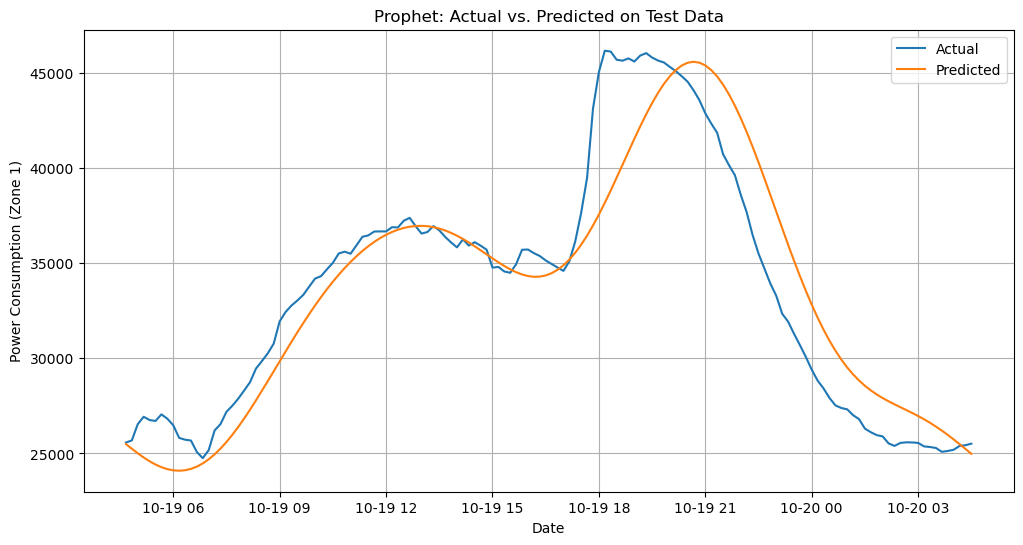

In [34]:
# 1. Create a future dataframe covering the test data's date range
future_test = pd.DataFrame({'ds': prophet_data_test['ds']})  

# 2. Make predictions for the test data period
forecast_test = model.predict(future_test)

# 3. Extract predicted values ('yhat') for comparison
predicted_values = forecast_test['yhat']

# 4. Extract actual values ('y') from the test data
actual_values = prophet_data_test['y']


# 6. Visual comparison
plt.figure(figsize=(12, 6))
plt.plot(prophet_data_test['ds'][:144], actual_values[:144], label='Actual')
plt.plot(prophet_data_test['ds'][:144], predicted_values[:144], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power Consumption (Zone 1)')
plt.title('Prophet: Actual vs. Predicted on Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# 5. Calculate metrics for comparison (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(actual_values[:144], predicted_values[:144]))
print(f"RMSE on test data: {rmse}")


RMSE on test data: 2470.999628634366


## Time Series Analysis - Neural Networks
### Using a moving window on the power consumption feature only. In this method, the input is 24 hours historical power consumption and the output is the next 24 hour power consumption. This would predict the next 24 hour power consumption based on historical data. For this reason, three different models were trained: a) Regular neural network b) A Simple Recurrent Neural Network (RNN), c) A Long Short-Term Memory (LSTM) network. The performance of the models have been compared with respect to the RMSE and also visually.  

In [39]:
# Preparing the data for the method that uses only power consumption signal
# Using only Power Consumption of Zone 1
data = df['PowerConsumption_Zone1']


# Create windows of historical and future data for training and testing
def create_sequences(data, hh, ff):
    X, y = [], []
    for i in range(len(data) - hh-ff):
        X.append(data[i:(i + hh)])
        y.append(data[(i+hh) : (i+hh+ff)])
        
    X=np.array(X)
    X=np.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = np.array(y)
    return X, y

# Define the length of the historicl and forecast indows 

history_length = 24 * 6 # there is 6 sample points for each hour (total 144 samples)
forecast_length = 24 * 6

# Convert the data into sequences of toime series data

X, y = create_sequences(data, history_length, forecast_length)
data.shape, X.shape, y.shape

((52416,), (52128, 1, 144), (52128, 144))

In [41]:
# Convert the data into test and training samples
num_train_samples = int(0.8*len(data))
X_train, y_train = X[:num_train_samples,:,:], y[:num_train_samples,:]
X_test, y_test = X[num_train_samples:,:,:], y[num_train_samples:,:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41932, 1, 144), (41932, 144), (10196, 1, 144), (10196, 144))

### a) Regular ANN Model 

In [180]:
# Build the Regular ANN model
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(50,activation="relu"))
model_dense.add(Dense(forecast_length,activation="relu"))
model_dense.compile(loss='mse', metrics=["mae"])

# Train the model
history_dense = model_dense.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred_dense = model_dense.predict(X_test)

Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 314201216.0000 - mae: 11366.2705
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 213490880.0000 - mae: 7795.0117
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - loss: 161293280.0000 - mae: 6281.4600
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 153422944.0000 - mae: 5958.9751
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 134037344.0000 - mae: 5377.2988
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - loss: 123779096.0000 - mae: 5043.5488
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 108446368.0000 - mae: 4590.6348
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 108391888.0000 - mae: 4578.3857
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 105967360.0000 - mae: 4511.4995
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 100280672.0000 - mae: 4334.4556
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━

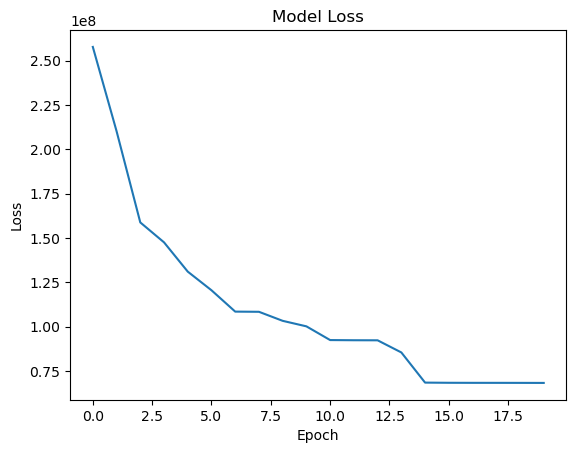

In [182]:
# Plot the loss function vs epochs for the regular ANN 
loss = history_dense.history['loss']
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [186]:
# Compute the RMSE of the Regular ANN Model
dens_mse = mean_squared_error(y_pred_dense[1,:],Original_signal)
dens_rmse = np.sqrt(dens_mse)
print(dens_mse, dens_rmse)

91313565.77513213 9555.813192770782


### b) Simple RNN Model

In [67]:
# Build the Simple RNN model 
model_simprnn = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation='relu'),  
    Dense(forecast_length)
])

# Compile 
model_simprnn.compile(loss='mse', metrics=["mae"])

# Train the model
history_simprnn = model_simprnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred_simprnn = model_simprnn.predict(X_test)

Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 79139280.0000 - mae: 5258.1069
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - loss: 8883841.0000 - mae: 2326.9092
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 7959224.5000 - mae: 2190.1804
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - loss: 7277365.5000 - mae: 2084.9805
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 6699798.5000 - mae: 1988.7543
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - loss: 6232004.5000 - mae: 1908.8956
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 5879232.0000 - mae: 1844.3666
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 5580031.0000 - mae: 1792.3358
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 5354744.5000 - mae: 1750.3586
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 5302316.0000 - mae: 1737.3859
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step -

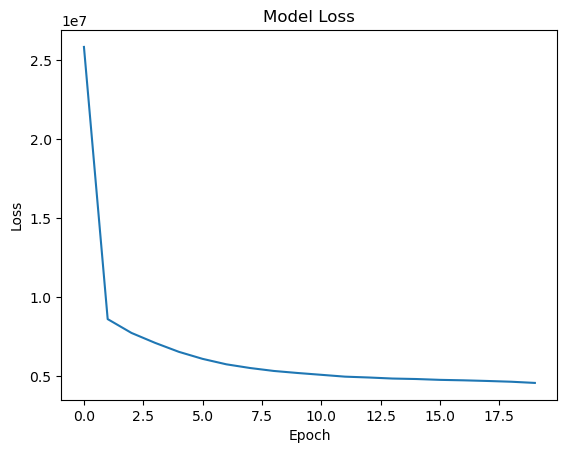

In [69]:
# Plot the loss function vs epochs for the simple RNN model
loss = history_simprnn.history['loss']
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [71]:
# Compute the RMSE of the Simple RNN Model
simprnn_mse = mean_squared_error(y_pred_simprnn[1,:],Original_signal)
simprnn_rmse = np.sqrt(simprnn_mse)
print(simprnn_mse, simprnn_rmse)

1860362.035941037 1363.950892056249


### c) LSTM Model

In [57]:
# Build the LSTM model
model_LSTM = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),  # No input_shape parameter here
    Dense(forecast_length)
])

# Compile 
model_LSTM.compile(loss='mse', metrics=["mae"])

# Train the model
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred_LSTM = model_LSTM.predict(X_test)

Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 147065344.0000 - mae: 7726.1353
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13014424.0000 - mae: 2866.6262
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9513193.0000 - mae: 2450.9216
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9228864.0000 - mae: 2416.1863
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8768458.0000 - mae: 2338.4246
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8086399.5000 - mae: 2218.2253
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7860864.5000 - mae: 2175.3413
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7721254.5000 - mae: 2155.2703
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7717632.5000 - mae: 2156.6875
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7661431.5000 - mae: 2149.8748
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7661520.0000 

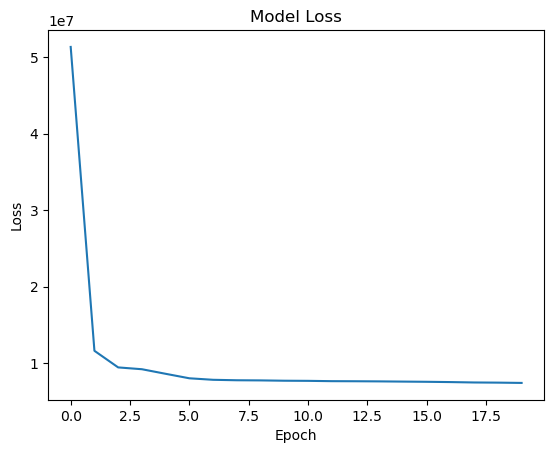

In [61]:
# Plot the loss function vs. epochs for the LTSM model.
loss = history_LSTM.history['loss']
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [63]:
# Compute the RMSE of the LSTM Model
LSTM_mse = mean_squared_error(y_pred_LSTM[1,:],Original_signal)
LSTM_rmse = np.sqrt(LSTM_mse)
print(LSTM_mse, LSTM_rmse)

1827969.8172201326 1352.0243404688144


## Time Series Analysis - Neural Networks - Multi Variable (Method 2)
### Using moving windows of historical 24 hour power consumption and temperature, and predicted 24 hour temperature, as input, and the predicted future 24 hour power consumption as output. Hence, the input has 3 components and the output has one component.  For this method, only LSTM was used. 

In [23]:
# The input and output variables are prepared

X_mix = df[['PowerConsumption_Zone1','Temperature']]
y_mix = df['PowerConsumption_Zone1']

# The function to produce the windows of data is adjusted to consider 3 input variables
    
def create_sequences_X(data, hh, ff):
  
    num_samples = len(data) - hh - ff + 1 

    X_m = []
    for i in range(num_samples):
        # Extract historical power and temperature
        historical_power = data.iloc[i : i + hh, 0].values  # PowerConsumption_Zone1
        historical_temp = data.iloc[i : i + hh, 1].values    # Temperature

        # Extract future temperature
        future_temp = data.iloc[i + hh : i + hh + ff, 1].values  # Temperature

        # Create a 3D array for this sample 
        sample_data = np.stack([historical_power, historical_temp, future_temp], axis=0)  
        
        X_m.append(sample_data)

    # Convert the list of 3D arrays to a single 3D array
    X_m = np.array(X_m) 

    return X_m

# The function to produce the windows of output data is created

def create_sequences_y(data, hh, ff):
    y_m = []
    for i in range(len(data) - hh-ff):
        y_m.append(data[(i+hh) : (i+hh+ff)])
        
    
    y_m = np.array(y_m)
    return y_m


# Slect the length of the moving windows
history_length = 24 * 6 # there is 6 sample points for each hour (144 samples)
forecast_length = 24 * 6

# Create the moving windows usning the above functions
X = create_sequences_X(X_mix, history_length, forecast_length)
y = create_sequences_y(y_mix, history_length, forecast_length)

# Check the dimentions of the data for accuracy
X.shape, y.shape

((52129, 3, 144), (52128, 144))

In [27]:
# The training and testing datasets are selected
num_train_samples = int(0.8*len(y_mix))
X_train, y_train = X[:num_train_samples,:,:], y[:num_train_samples,:]
X_test, y_test = X[num_train_samples:,:,:], y[num_train_samples:,:]

# Dimentions of the training and testing data sets are checked for accuracy
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41932, 3, 144), (41932, 144), (10197, 3, 144), (10196, 144))

### a) Muti-Variable LSTM

In [73]:
# Build the LSTM model with forecasted temperature as input
model_LSTM_ft = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),  # No input_shape parameter here
    Dense(forecast_length)
])

# Compile
model_LSTM_ft.compile(optimizer='RMSProp', loss='mse', metrics=["mae"])

# Train the model
history_LSTM_ft = model_LSTM_ft.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred_LSTM_ft = model_LSTM_ft.predict(X_test)

Epoch 1/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 109137184.0000 - mae: 6369.2119
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9612665.0000 - mae: 2440.7571
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7860493.5000 - mae: 2166.8723
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7082520.5000 - mae: 2037.7686
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6792931.0000 - mae: 1988.3085
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6545891.0000 - mae: 1939.3268
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6195681.0000 - mae: 1885.5375
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6040032.0000 - mae: 1857.9238
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5882971.0000 - mae: 1834.1439
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5884399.5000 - mae: 1825.7271
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5830260.0000 -

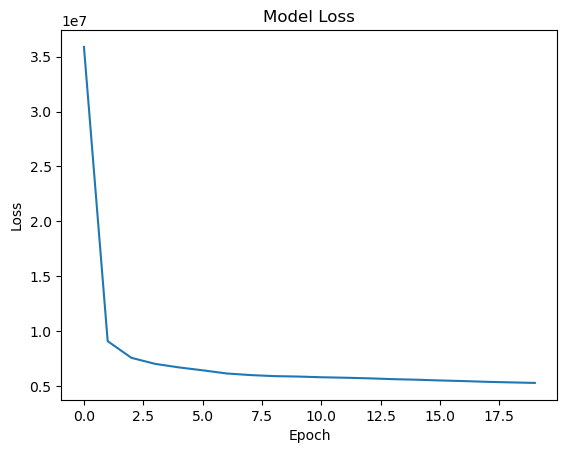

In [76]:
# Plot the loss function for the new method
loss = history_LSTM_ft.history['loss']
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [78]:
# Compute the RMSE of the Multi-Variable LSTM Model
LSTM_ft_mse = mean_squared_error(y_pred_LSTM_ft[1,:],Original_signal)
LSTM_ft_rmse = np.sqrt(LSTM_ft_mse)
print(LSTM_ft_mse, LSTM_ft_rmse)

1900048.9676267123 1378.4226375196804


### b) Hyper Parameter Tuning for Multi-Variable LSTM

In [90]:
# Hyper-Parameter tuning

def create_model(units=50, learning_rate=0.001, optimizer='adam'):
    model = keras.models.Sequential([
        keras.Input(shape=(X_train.shape[1], X_train.shape[2])),  # Explicit input layer
        keras.layers.LSTM(units, activation='relu'),
        keras.layers.Dense(forecast_length)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Wrap the model using scikeras
regressor = KerasRegressor(
    model=create_model,
    verbose=0,
    epochs=10,          # Default values — will be overwritten by param_dist
    batch_size=32
)

# Define the hyperparameter grid
param_dist = {
    'model__units': [75, 100, 200],            # LSTM units
    'model__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],   # Learning rate
    'model__optimizer': ['adam'],      # Optimizer name
    'batch_size': [32],                   # Batch size
    'epochs': [20]                            # Number of epochs
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_dist,
    n_iter=12,
    cv=2,
    verbose=1,
    n_jobs=1,
    scoring='neg_mean_absolute_error'
)

# Fit the model
random_search_result = random_search.fit(X_train, y_train)

# Output results
print("Best hyperparameters:", random_search_result.best_params_)
print("Best score (MAE):", -random_search_result.best_score_)

# Evaluate on test set
best_model = random_search_result.best_estimator_


# Make predictions
y_pred_best_model = best_model.predict(X_test)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best hyperparameters: {'model__units': 200, 'model__optimizer': 'adam', 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
Best score (MAE): 1522.240838701839


In [95]:
# Compute the RMSE of the Multi-Variable LSTM Model with Hyper Parameter Tuning
est_model_ft_mse = mean_squared_error(y_pred_best_model[1,:],Original_signal)
est_model_ft_rmse = np.sqrt(est_model_ft_mse)
print(est_model_ft_mse , est_model_ft_rmse)

741100.9853371897 860.872223583262


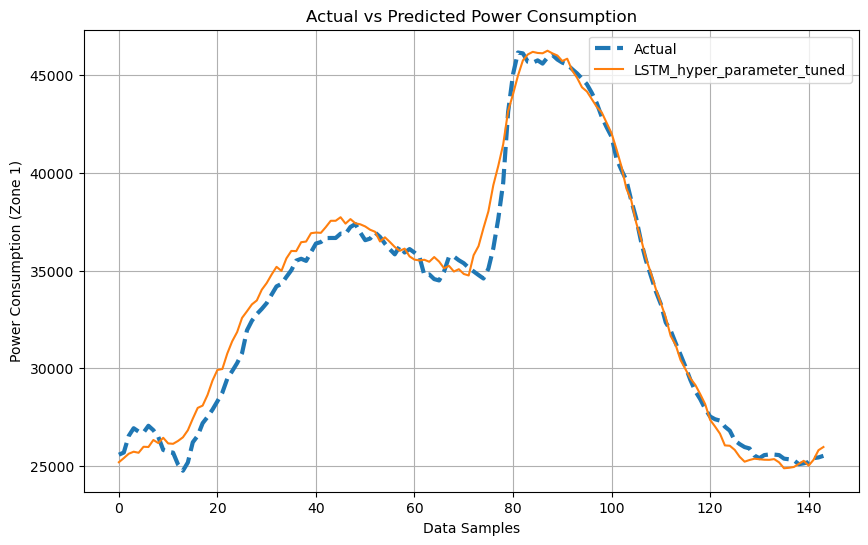

In [103]:
# Visual comparison of all neural network models versus the actual measured data
Original_signal_1=Original_signal.reset_index(drop=True).T
plt.figure(figsize=(10, 6))
plt.plot(Original_signal_1, label='Actual', linestyle='--', linewidth=3)  # Modified line
plt.plot(y_pred_best_model[1,:], label='LSTM_hyper_parameter_tuned')
plt.xlabel("Data Samples")
plt.ylabel("Power Consumption (Zone 1)")
plt.title("Actual vs Predicted Power Consumption")
plt.legend()
plt.grid(True)
plt.show()